# Figure 1
Mice rely on hyperbolic rather than exponential weighting of rewarded-choice history during history-dependent value-based decision-making.

In [1]:
%load_ext autoreload

## General import functions

In [2]:
%reset -f
import sys
from os.path import dirname, join as pjoin
from os import listdir
sys.path.append('C:\\jupyter_notebooks\\Danskin_SciAdv_2023\\py_code') # set local directory
import numpy as np
import pickle
import random
import xarray as xr
import pandas as pd

import h5py
import scipy.io as sio
from scipy import stats
import statsmodels as sm # import statsmodels.api as sm
from scipy.optimize import minimize, basinhopping, curve_fit
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm, trange

In [3]:
## Directories
%autoreload
import bdanskin as BD 

project_dir = 'C:\\jupyter_notebooks\\Danskin_SciAdv_2023' # local directory
imaging_dir = pjoin(project_dir, 'hattori_datasets_xarray')
cellfits_dir = pjoin(project_dir, 'hattori_datasets_xarray_cellfits')
behavior_dir = pjoin(project_dir, 'hattori_datasets_behavior')

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
fig_save_dir = 'ms_figures_230623'

## General plotting functions

In [5]:
plt_colors = BD.plt_color_dir()
def sem(y):
    if len(np.shape(y))==1:
        return np.nanstd(y)/np.sqrt(len(y)-1)
    else:
        n,_ = np.shape(y)
        return np.nanstd(y,0)/np.sqrt(n-1)

def plt_remove_spines(ax):
    if len(np.shape(ax))>1:
        ax_y, ax_x = np.shape(ax)
        for xx in range(ax_x):
            for yy in range(ax_y):
                ax[yy,xx].spines['top'].set_visible(False)
                ax[yy,xx].spines['right'].set_visible(False)
    else:
        for xx in range(len(ax)):
            ax[xx].spines['top'].set_visible(False)
            ax[xx].spines['right'].set_visible(False)

def stats_compare(y):
    if np.nanmean(y)>0:
        pos_neg = 1
    else:
        pos_neg = -1
        
    _,pnorm = stats.normaltest(y)
    if pnorm<0.05:
        h_norm = 0
        _, pval = stats.wilcoxon(y)
        print('wilcoxon')
    else:
        h_norm = 1
        _, pval = stats.ttest_1samp(y,0.0)
        print('ttest')
        
    h_lvl = 0
    if (pval<0.05) & (pval>=0.01):
        h_lvl = 1
    elif (pval<0.01) & (pval>=0.001):
        h_lvl = 2
    elif (pval<0.001) & (pval>=0.0001):
        h_lvl = 3
    elif (pval<0.0001):
        h_lvl = 4
    return pval, h_lvl, h_norm, pos_neg

def sig_text(pval):
    sig_lvl = 0
    if (pval<0.05) & (pval>=0.01):
        sig_lvl = 1
    elif (pval<0.01) & (pval>=0.001):
        sig_lvl = 2
    elif (pval<0.001) & (pval>=0.0001):
        sig_lvl = 3
    elif (pval<0.0001):
        sig_lvl = 4

    if sig_lvl==4:
        txt_out = '****'
    elif sig_lvl==3:
        txt_out = '***'  
    elif sig_lvl==2:
        txt_out = '**'      
    elif sig_lvl==1:
        txt_out = '*'
    else:
        txt_out = 'n.s.'
    return txt_out

def add_sig_plt(ax,x_ind,y_ind,font_size,pval,sig_lvl,pos_neg):
    plt_clr = 'k'
    if pos_neg==1:
        plt_clr = 'r'
        
    if sig_lvl==-1:    # catch for mixedeffects that have no sig lvl
        sig_lvl = 0
        if (pval<0.05) & (pval>=0.01):
            sig_lvl = 1
        elif (pval<0.01) & (pval>=0.001):
            sig_lvl = 2
        elif (pval<0.001) & (pval>=0.0001):
            sig_lvl = 3
        elif (pval<0.0001):
            sig_lvl = 4

    if sig_lvl==4:
        ax.text(x_ind,y_ind,'****',color=plt_clr,fontsize = font_size, transform = ax.transAxes)
    if sig_lvl==3:
        ax.text(x_ind,y_ind,'***',color=plt_clr,fontsize = font_size, transform = ax.transAxes)  
    if sig_lvl==2:
        ax.text(x_ind,y_ind,'**',color=plt_clr,fontsize = font_size, transform = ax.transAxes)      
    if sig_lvl==1:
        ax.text(x_ind,y_ind,'*',color=plt_clr,fontsize = font_size, transform = ax.transAxes)

## Specific plotting functions

#### decay functions

In [6]:
def exp_single(x, a, b):
    return a * np.exp(x/b)
def hyper(x, a,b):
    return a/(1-(x)/b)
# Fit decay functions
def fit_decay_parameters(x_ind,weights):
    decay_analysis = {'x_ind': x_ind,
                      'weights': weights}
    # Fit exponential
    popt, _ = curve_fit(exp_single, x_ind, weights,p0=(2,1))# ,bounds=([0,0],[5,np.inf]))
    print(popt)
    AIC = calc_aic(x_ind, weights, exp_single, popt)
    decay_analysis['single_exp'] = popt
    decay_analysis['single_exp_AIC'] = AIC
     
    # Fit Hyperbolic
    popt, _ = curve_fit(hyper, x_ind, weights,p0=(0.1,2))
    print(popt)
    AIC = calc_aic(x_ind, weights, hyper, popt)
    decay_analysis['hyper'] = popt
    decay_analysis['hyper_AIC'] = AIC
    return decay_analysis
def calc_aic(x,y,func, params):
    k = len(params)
    y_pred = func(x,*params)
    resid = y - y_pred
    sse = sum(resid ** 2)

    AIC = 2*k + len(y)*np.log(sse)
    return AIC

#### delta loglik

In [7]:
def delta_loglik_func(temp_ds_1,temp_ds_2,mdl_type_1,mdl_type_2,n_hist):
    y_out = (temp_ds_1.loc[((temp_ds_1['mdl_type']==mdl_type_1) & 
                           (temp_ds_1['mdl_hist']==n_hist)), 'CV_mean_norm_loglik'] -
             temp_ds_2.loc[((temp_ds_2['mdl_type']==mdl_type_2) & 
                           (temp_ds_2['mdl_hist']==n_hist)), 'CV_mean_norm_loglik']).values
    return y_out

#### box plots

In [8]:
def plot_colored_boxplot(ax,data_vec,x_pos,tmp_c):
    ax.boxplot(data_vec, positions=[x_pos], widths=.4, notch=False, showfliers=False,
           patch_artist=True,
           boxprops=dict(facecolor='none',color=tmp_c,linewidth=1.5),
           capprops=dict(color=tmp_c,linewidth=1.5),
           whiskerprops=dict(color=tmp_c,linewidth=1.5),
           medianprops=dict(color=tmp_c,linewidth=1.5),
            )
def plot_bxplt(ax, y, x, clr):
    ax.boxplot([y], positions=[x], widths=0.35, notch=False,showfliers=False,
               patch_artist=True,
               boxprops=dict(facecolor='none',color=clr,linewidth=1.0),
               capprops=dict(color=clr,linewidth=1.0),
               whiskerprops=dict(color=clr,linewidth=1.0),
               medianprops=dict(color=clr,linewidth=1.0))

## Plot example session

In [9]:
session = 'RH824_170824_ALM_l'
print(session)
filesavename = pjoin(behavior_dir,'imaging_processed_data_behonly','{}.pkl'.format(session))
session_behavior = pickle.load(open(filesavename,'rb'))

files_savename = pjoin(behavior_dir, 'logstic_imaging_10_hist.pkl')
reg_beh= pickle.load(open(files_savename,'rb'))
session_results = reg_beh.loc[(reg_beh['Date']==session[6:12])]

RH824_170824_ALM_l


### [Plt] session example

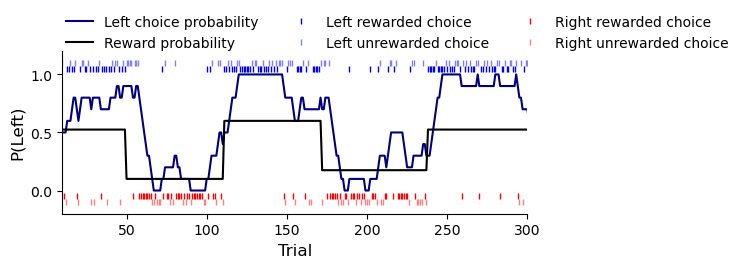

In [10]:
f,ax = plt.subplots(1,1, figsize = [6, 2.5], tight_layout=False)
X_min = 10
X_max = 300

a = session_behavior.a.values
choice_trials = (a==1)|(a==2)
choice_trials[:245]=False
a = a[choice_trials]

num_trial = len(a)
x_ind = np.arange(1,num_trial+1)

left_choice = (session_behavior.loc[choice_trials,'a'].reset_index(drop=True)==1)+0
left_smooth = left_choice.rolling(10).mean()
R = session_behavior.loc[choice_trials,'R'].reset_index(drop=True) #.values
p_left = session_behavior.loc[choice_trials,'P(Left)'].reset_index(drop=True) #.values

# make lick ticks
left_reward = np.empty(num_trial); left_reward[:] = np.nan
left_unreward = np.empty(num_trial); left_unreward[:] = np.nan
right_reward = np.empty(num_trial); right_reward[:] = np.nan
right_unreward = np.empty(num_trial); right_unreward[:] = np.nan
left_reward[(a==1) & (R==1)] = 1
right_reward[(a==2) & (R==1)] = 1
left_unreward[(a==1) & (R==0)] = 1
right_unreward[(a==2) & (R==0)] = 1

ax.plot(x_ind,left_smooth,c=[0,0,.5], label='Left choice probability')
ax.plot(x_ind,p_left,color='k', label='Reward probability')
ax.plot(x_ind,left_reward+.05,'|',color=[0,0,1],markersize=5,linewidth=1, label='Left rewarded choice')
ax.plot(x_ind,left_unreward+.1, '|',color=[.5,.5,1],markersize=5,linewidth=1, label='Left unrewarded choice')
ax.plot(x_ind,right_reward-1.05,'|',color=[1,0,0],markersize=5,linewidth=1, label='Right rewarded choice')
ax.plot(x_ind,right_unreward-1.1,'|',color=[1,.5,.5],markersize=5,linewidth=1, label='Right unrewarded choice')
ax.legend(loc='upper left',frameon=False,ncol=3,bbox_to_anchor=(-.02,1.3,0,0),fontsize=10)

ax.set_xlim([X_min, X_max])
ax.set_ylim([-.2, 1.2])
ax.set_ylabel('P(Left)',fontsize=12)
ax.set_xlabel('Trial',fontsize=12)
ax.set_yticks([0,.5,1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

f.subplots_adjust(left=None, bottom=0.2, right=None, top=0.85, wspace=None, hspace=None)
# f.savefig(pjoin(fig_save_dir,'1_beh','session_example_{}.png'.format(session)))
# f.savefig(pjoin(fig_save_dir,'1_beh','session_example_{}.svg'.format(session)))

### [Plt] logistic weights example

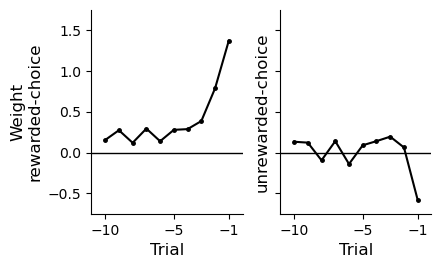

In [12]:
f,ax = plt.subplots(1,2, sharex=True, sharey=True, figsize = [5, 3.0], tight_layout=False)
n_back = 10
y_lim = [-0.75,1.75]
x_plt = -np.linspace((n_back),1,n_back)
all_weights = session_results['RU_weights'].values[0]
rewc_weights = all_weights[:n_back].copy(); 
unrc_weights = all_weights[n_back:2*n_back]

ax[0].plot([-11,0],[0,0],'-k',linewidth=1)
ax[0].plot(x_plt,rewc_weights,'.-k',ms=5)
ax[0].set_ylabel('Weight\nrewarded-choice',fontsize=12)
# ax[0].set_title('Example session',fontsize=12)
ax[0].set_xlabel('Trial',fontsize=12)

ax[1].plot([-11,0],[0,0],'-k',linewidth=1)
ax[1].plot(x_plt,unrc_weights,'.-k',ms=5)
ax[1].set_ylabel('unrewarded-choice',fontsize=12)
ax[1].set_xlabel('Trial',fontsize=12)
ax[1].set_ylim(y_lim)
ax[1].set_xlim([-11,0])
ax[1].set_yticks([-0.5,0,.5,1,1.5])
ax[1].set_xticks([-10,-5,-1])


ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
f.subplots_adjust(left=0.22, bottom=0.2, right=None, top=None, wspace=0.25, hspace=None)
# f.savefig(pjoin(fig_save_dir,'1_beh','weights_example_{}.png'.format(session)))
# f.savefig(pjoin(fig_save_dir,'1_beh','weights_example_{}.svg'.format(session)))

## Plot session logistics means

### Load and prep data

In [13]:
files_savename = pjoin(behavior_dir, 'logstic_imaging_10_hist.pkl')
logistic_expert = pickle.load(open(files_savename,'rb'))

files_savename = pjoin(behavior_dir, 'logstic_full_rl_10_hist.pkl')
logistic_full = pickle.load(open(files_savename,'rb'))

files_savename = pjoin(behavior_dir, 'logstic_base_rl_10_hist.pkl')
logistic_base = pickle.load(open(files_savename,'rb'))

logistic_expert = logistic_expert.iloc[:74]
logistic_full = logistic_full.iloc[:74]
logistic_base = logistic_base.iloc[:74]

In [14]:
weight_type = 'RU_weights'
n_back = 10

logit_weights_expert = np.zeros([len(logistic_expert),n_back])
for ii in range(len(logistic_expert)):
    logit_weights_expert[ii,:] = logistic_expert.loc[ii, weight_type][:n_back]

logit_weights_base = np.zeros([len(logistic_base),10])
for ii in range(len(logistic_base)):
    logit_weights_base[ii,:] = logistic_base.loc[ii, weight_type][:n_back]

logit_weights_full = np.zeros([len(logistic_full),10])
for ii in range(len(logistic_full)):
    logit_weights_full[ii,:] = logistic_full.loc[ii, weight_type][:n_back]

### [Plt] Grandmean of weights

[1.47440267 2.33013116]
[1.56258326 1.0215235 ]
[1.1676661  3.11531526]
[1.23686934 1.44727147]


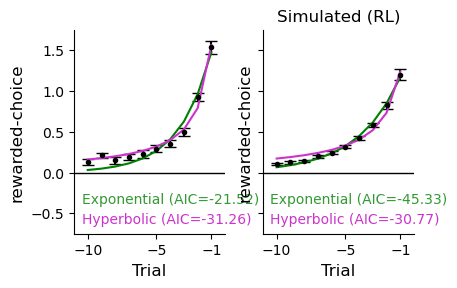

In [15]:
f,ax = plt.subplots(1,2, sharey=True, sharex=True, figsize = [5,3.0], tight_layout=False)
n_back = 10
x_ind = -np.linspace((n_back-1),0,n_back)
x_plt = -np.linspace((n_back),1,n_back)
y_lim = [-0.75,1.75]

# Real
ax[0].plot([-11,0],[0,0],'-k',linewidth=1)
y_mean = np.mean(logit_weights_expert,axis=0)
y_err = np.std(logit_weights_expert,axis=0)/np.sqrt(len(logit_weights_expert)/2-1)
ax[0].errorbar(x_plt,y_mean,y_err,c='k',
               marker='o', markersize=3,
               linestyle='none',capsize=4)
decay_analysis = fit_decay_parameters(x_ind,y_mean)


ax[0].plot(x_plt,exp_single(x_ind,*decay_analysis['single_exp']),color=plt_colors['exp'], label='exponential')
ax[0].plot(x_plt,hyper(x_ind,*decay_analysis['hyper']),color=plt_colors['hyp'], label='hyperbolic')
ax[0].text(0.05,.15,'Exponential (AIC={})'.format(np.round(decay_analysis['single_exp_AIC'],2)),
           color=[.2, .6, .2],fontsize=10, transform = ax[0].transAxes)
ax[0].text(0.05,.05,'Hyperbolic (AIC={})'.format(np.round(decay_analysis['hyper_AIC'],2)),
           color=[.8, .2, .8],fontsize=10, transform = ax[0].transAxes)
ax[0].set_ylabel('rewarded-choice', fontsize=12)
# ax[0].set_title('Mice', fontsize=12)
ax[0].set_ylim(y_lim)
ax[0].set_xlim([-11,0])
ax[0].set_yticks([-0.5,0,.5,1,1.5])
ax[0].set_xticks([-10,-5,-1])
ax[0].set_xlabel('Trial', fontsize=12)
# ax.legend(loc='upper left', frameon=False, fontsize=12)

# Simulation
ax[1].plot([-11,0],[0,0],'-k',linewidth=1)
y_mean = np.mean(logit_weights_full,axis=0)
y_err = np.std(logit_weights_full,axis=0)/np.sqrt(len(logit_weights_full)/2-1)
ax[1].errorbar(x_plt,y_mean,y_err,c='k',
               marker='o', markersize=3,
               linestyle='none',capsize=4)
decay_analysis = fit_decay_parameters(x_ind,y_mean)

ax[1].plot(x_plt,exp_single(x_ind,*decay_analysis['single_exp']),color=plt_colors['exp'], label='exponential')
ax[1].plot(x_plt,hyper(x_ind,*decay_analysis['hyper']),color=plt_colors['hyp'], label='hyperbolic')
ax[1].text(0.05,.15,'Exponential (AIC={})'.format(np.round(decay_analysis['single_exp_AIC'],2)),
           color=[.2, .6, .2],fontsize=10, transform = ax[1].transAxes)
ax[1].text(0.05,.05,'Hyperbolic (AIC={})'.format(np.round(decay_analysis['hyper_AIC'],2)),
           color=[.8, .2, .8],fontsize=10, transform = ax[1].transAxes)

ax[1].set_title('Simulated (RL)', fontsize=12)
ax[1].set_ylim(y_lim)
ax[1].set_xlim([-11,0])
ax[1].set_yticks([-0.5,0,.5,1,1.5])
ax[1].set_xticks([-10,-5,-1])
ax[1].set_xlabel('Trial', fontsize=12)
ax[1].set_ylabel('rewarded-choice', fontsize=12)
# ax.legend(loc='upper left', frameon=False, fontsize=12)

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
f.subplots_adjust(left=0.22, bottom=0.2, right=None, top=None, wspace=0.25, hspace=None)
# f.savefig(pjoin(fig_save_dir,'1_beh','RC_logistic_regression_grandmean.png'))
# f.savefig(pjoin(fig_save_dir,'1_beh','RC_logistic_regression_grandmean.svg'))

### Plot unrewarded weights

In [16]:
weight_type = 'RU_weights'
n_back = 10

logit_weights_expert = np.zeros([len(logistic_expert),n_back])
for ii in range(len(logistic_expert)):
    logit_weights_expert[ii,:] = logistic_expert.loc[ii, weight_type][n_back:2*n_back]

logit_weights_base = np.zeros([len(logistic_base),n_back])
for ii in range(len(logistic_base)):
    logit_weights_base[ii,:] = logistic_base.loc[ii, weight_type][n_back:2*n_back]

logit_weights_full = np.zeros([len(logistic_full),n_back])
for ii in range(len(logistic_full)):
    logit_weights_full[ii,:] = logistic_full.loc[ii, weight_type][n_back:2*n_back]

### [Plt] UC Grandmean of weights

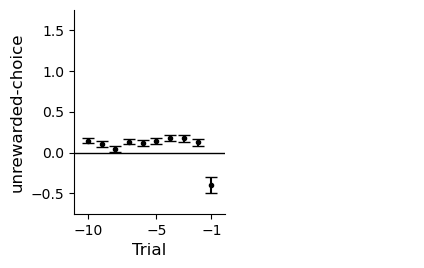

In [18]:
f,ax = plt.subplots(1,2, sharey=True, sharex=True, figsize = [5,3.0], tight_layout=False)
n_back = 10
x_ind = -np.linspace((n_back-1),0,n_back)
x_plt = -np.linspace((n_back),1,n_back)
y_lim = [-0.75,1.75]

# Real
ax[0].plot([-11,0],[0,0],'-k',linewidth=1)
y_mean = np.mean(logit_weights_expert,axis=0)
y_err = np.std(logit_weights_expert,axis=0)/np.sqrt(len(logit_weights_expert)/2-1)
ax[0].errorbar(x_plt,y_mean,y_err,c='k',
               marker='o', markersize=3,
               linestyle='none',capsize=4)

ax[0].set_ylim(y_lim)
ax[0].set_xlim([-11,0])
ax[0].set_yticks([-0.5,0,.5,1,1.5])
ax[0].set_xticks([-10,-5,-1])
ax[0].set_xlabel('Trial', fontsize=12)
ax[0].set_ylabel('unrewarded-choice', fontsize=12)
# ax.legend(loc='upper left', frameon=False, fontsize=12)

ax[1].axis('off')

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
f.subplots_adjust(left=0.22, bottom=0.2, right=None, top=None, wspace=0.25, hspace=None)
# f.savefig(pjoin(fig_save_dir,'1_beh','UC_logistic_regression_grandmean.png'))
# f.savefig(pjoin(fig_save_dir,'1_beh','UC_logistic_regression_grandmean.svg'))

## Plot behlogits

### Load and prep data

In [19]:
files_savename = pjoin(behavior_dir,'behlogit_imaging_15_hist.pkl')
behlogit_expert = pickle.load(open(files_savename,'rb'))

files_savename = pjoin(behavior_dir,'behlogit_imaging_15_hist_constrained.pkl')
behlogit_con_expert = pickle.load(open(files_savename,'rb'))

files_savename = pjoin(behavior_dir,'behlogit_rl_full_15_hist.pkl')
behlogit_full = pickle.load(open(files_savename,'rb'))

files_savename = pjoin(behavior_dir,'behlogit_rl_base_15_hist.pkl')
behlogit_base = pickle.load(open(files_savename,'rb'))

behlogit_expert = behlogit_expert.loc[behlogit_expert.index<75]
behlogit_con_expert = behlogit_con_expert.loc[behlogit_con_expert.index<75]
behlogit_full = behlogit_full.loc[behlogit_full.index<75]
behlogit_base = behlogit_base.loc[behlogit_base.index<75]

### [Plt] compare exp_r, hyp_r (LL)

wilcoxon
ttest
[1.60592076e-11 1.12925600e-15]
median, real: 4.69e-03, sim: -3.57e-03


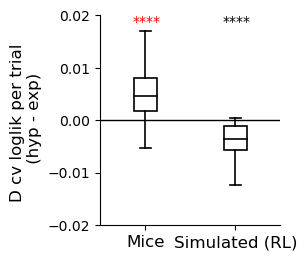

In [20]:
f,ax = plt.subplots(1,1, sharey=True, sharex=True, figsize = [3, 3], tight_layout=False)
real_15 = delta_loglik_func(behlogit_expert, behlogit_expert ,'hyp_r','exp_r',15)
sim_15 = delta_loglik_func(behlogit_full, behlogit_full ,'hyp_r','exp_r',15)
with_txt=False

ax.plot([0,14],[0,0],'-k', linewidth=1)
ax.boxplot([real_15,sim_15],
              widths=0.25,
              notch=False,
              showfliers=False,
           patch_artist=True,
           boxprops=dict(facecolor='none',color='k',linewidth=1.2),
           capprops=dict(color='k',linewidth=1.2),
           whiskerprops=dict(color='k',linewidth=1.2),
           medianprops=dict(color='k',linewidth=1.2))
ax.set_ylim([-.02,.02])
ax.set_xlim([.5,2.5])
# ax.set_ylabel(r'$\Delta$ loglik (Hyp(R) - Exp(R))',fontsize=10)
ax.set_ylabel('D cv loglik per trial \n (hyp - exp)',fontsize=12)
ax.set_xticks([1,2])
ax.set_xticklabels(['Mice','Simulated (RL)'],fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

f.subplots_adjust(left=0.3, bottom=0.18, right=None, top=None, wspace=None, hspace=None)
if with_txt:
    ax.text(.65,1.35,'p =',fontsize=8)
    pval, sig_lvl, h_norm, pos_neg = stats_compare(real_15); pval_vec = pval
    ax.text(1-0,1.35,'{0:.1e}'.format(pval),c='r',fontsize=8)
    pval, sig_lvl, h_norm, pos_neg = stats_compare(sim_15); pval_vec = np.append(pval_vec,pval)
    ax.text(2-.2,1.35,'{0:.1e}'.format(pval),c='k',fontsize=8)
    # f.savefig(pjoin(fig_save_dir,'1_beh','delta_ll_exp_hyp_w_txt.png'))
    # f.savefig(pjoin(fig_save_dir,'1_beh','delta_ll_exp_hyp_w_txt.svg'))
else:
    pval, sig_lvl, h_norm, pos_neg = stats_compare(real_15); pval_vec = pval
    add_sig_plt(ax,.18,.95,10,pval,sig_lvl,pos_neg)
    pval, sig_lvl, h_norm, pos_neg = stats_compare(sim_15); pval_vec = np.append(pval_vec,pval)
    add_sig_plt(ax,.68,.95,10,pval,sig_lvl,pos_neg)
    # f.savefig(pjoin(fig_save_dir,'1_beh','delta_ll_exp_hyp.png'))
    # f.savefig(pjoin(fig_save_dir,'1_beh','delta_ll_exp_hyp.svg'))
print(pval_vec)
print('median, real: {0:.2e}, sim: {1:.2e}'.format(np.nanmedian(real_15), np.nanmedian(sim_15)))

In [21]:
print('Medians: {0:.2e}, {1:.2e}'.format(np.median(real_15), np.median(sim_15)))
# import statsmodels as sm
_,pval_fdr,_,_ = sm.stats.multitest.multipletests(pval_vec, alpha=0.05,method='fdr_bh')
_,pval_b,_,_ = sm.stats.multitest.multipletests(pval_vec, alpha=0.05,method='b')
print('p values without multicompare are: {0:.2e} {1:.2e}'.format(*pval_vec))
print('p values with FDR (BH) are: {0:.2e} {1:.2e}'.format(*pval_fdr))
print('p values with bonferoni are: {0:.2e} {1:.2e}'.format(*pval_b))

Medians: 4.69e-03, -3.57e-03
p values without multicompare are: 1.61e-11 1.13e-15
p values with FDR (BH) are: 1.61e-11 2.26e-15
p values with bonferoni are: 3.21e-11 2.26e-15


### Load history behlogits

In [22]:
files_savename = pjoin(behavior_dir,'behlogit_imaging_compare_hist.pkl')
behlogit_expert = pickle.load(open(files_savename,'rb'))

files_savename = pjoin(behavior_dir,'behlogit_rl_full_compare_hist.pkl')
behlogit_full = pickle.load(open(files_savename,'rb'))

files_savename = pjoin(behavior_dir,'behlogit_rl_base_compare_hist.pkl')
behlogit_base = pickle.load(open(files_savename,'rb'))

behlogit_expert = behlogit_expert.loc[behlogit_expert.index<75]
behlogit_full = behlogit_full.loc[behlogit_full.index<75]
behlogit_base = behlogit_base.loc[behlogit_base.index<75]

### [Plt] supplement: history compare exp_r, hyp_r for expert, simulated

ttest
wilcoxon
wilcoxon
wilcoxon
p values without multicompare are: 3.55e-03 1.12e-11 1.61e-11 2.34e-09
p values with FDR (BH) are: 3.55e-03 3.21e-11 3.21e-11 3.12e-09
wilcoxon
wilcoxon
ttest
ttest
p values without multicompare are: 2.41e-01 1.98e-10 1.13e-15 2.71e-18
p values with FDR (BH) are: 2.41e-01 2.64e-10 2.26e-15 1.08e-17


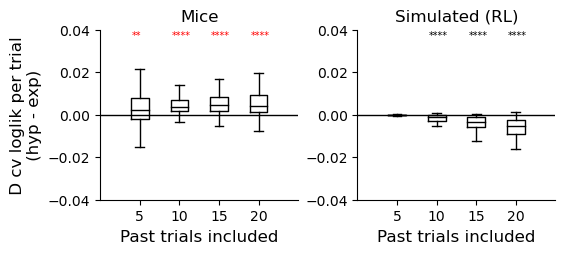

In [23]:
f,ax = plt.subplots(1,2, sharey=False, sharex=True, figsize = [6.5, 2.5])

## Expert Data
y_5 = delta_loglik_func(behlogit_expert, behlogit_expert ,'hyp_r','exp_r',30)
y_10 = delta_loglik_func(behlogit_expert, behlogit_expert ,'hyp_r','exp_r',10)
y_15 = delta_loglik_func(behlogit_expert, behlogit_expert ,'hyp_r','exp_r',15)
y_20 = delta_loglik_func(behlogit_expert, behlogit_expert ,'hyp_r','exp_r',20)
ax[0].plot([0,14],[0,0],'-k',linewidth=1)
ax[0].boxplot([y_5,y_10,y_15,y_20],
              notch=False,
              showfliers=False,
              medianprops={'c':'k'})
ax[0].set_title('Mice',fontsize=12)
ax[0].set_ylim([-.04,.04])
ax[0].set_xlim([0,5])
# ax[0].set_ylabel(r'$\Delta$ loglik (Hyp(R) - Exp(R))',fontsize=10)
ax[0].set_ylabel(' D cv loglik per trial \n (hyp - exp) ',fontsize=12)
ax[0].set_xticks([1,2,3,4])
ax[0].set_xticklabels(['5','10','15','20'])#rotation=45)
ax[0].set_xlabel('Past trials included',fontsize=12)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

pval, sig_lvl, h_norm, pos_neg = stats_compare(y_5); pval_vec = pval
add_sig_plt(ax[0],.16,.95,7,pval,sig_lvl,pos_neg)
pval, sig_lvl, h_norm, pos_neg = stats_compare(y_10); pval_vec = np.append(pval_vec,pval)
add_sig_plt(ax[0],.36,.95,7,pval,sig_lvl,pos_neg)
pval, sig_lvl, h_norm, pos_neg = stats_compare(y_15); pval_vec = np.append(pval_vec,pval)
add_sig_plt(ax[0],.56,.95,7,pval,sig_lvl,pos_neg)
pval, sig_lvl, h_norm, pos_neg = stats_compare(y_20); pval_vec = np.append(pval_vec,pval)
add_sig_plt(ax[0],.76,.95,7,pval,sig_lvl,pos_neg)
_,pval_fdr,_,_ = sm.stats.multitest.multipletests(pval_vec, alpha=0.05,method='fdr_bh')
print('p values without multicompare are: {0:.2e} {1:.2e} {2:.2e} {3:.2e}'.format(*pval_vec))
print('p values with FDR (BH) are: {0:.2e} {1:.2e} {2:.2e} {3:.2e}'.format(*pval_fdr))

# ## Full RL Data
y_5 = delta_loglik_func(behlogit_full, behlogit_full ,'hyp_r','exp_r',5)
y_10 = delta_loglik_func(behlogit_full, behlogit_full ,'hyp_r','exp_r',10)
y_15 = delta_loglik_func(behlogit_full, behlogit_full ,'hyp_r','exp_r',15)
y_20 = delta_loglik_func(behlogit_full, behlogit_full ,'hyp_r','exp_r',20)

ax[1].plot([0,14],[0,0],'-k',linewidth=1)
ax[1].boxplot([y_5,y_10,y_15,y_20],
              notch=False,
              showfliers=False,
              medianprops={'c':'k'})
ax[1].set_title('Simulated (RL)',fontsize=12)
ax[1].set_xlabel('Past trials included',fontsize=12)
ax[1].set_xticks([1,2,3,4])
ax[1].set_xticklabels(['5','10','15','20'])#,rotation=45)
ax[1].set_ylim([-.04,.04])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

pval, sig_lvl, h_norm, pos_neg = stats_compare(y_5); pval_vec = pval
add_sig_plt(ax[1],.16,.95,7,pval,sig_lvl,pos_neg)
pval, sig_lvl, h_norm, pos_neg = stats_compare(y_10); pval_vec = np.append(pval_vec,pval)
add_sig_plt(ax[1],.36,.95,7,pval,sig_lvl,pos_neg)
pval, sig_lvl, h_norm, pos_neg = stats_compare(y_15); pval_vec = np.append(pval_vec,pval)
add_sig_plt(ax[1],.56,.95,7,pval,sig_lvl,pos_neg)
pval, sig_lvl, h_norm, pos_neg = stats_compare(y_20); pval_vec = np.append(pval_vec,pval)
add_sig_plt(ax[1],.76,.95,7,pval,sig_lvl,pos_neg)
_,pval_fdr,_,_ = sm.stats.multitest.multipletests(pval_vec, alpha=0.05,method='fdr_bh')
print('p values without multicompare are: {0:.2e} {1:.2e} {2:.2e} {3:.2e}'.format(*pval_vec))
print('p values with FDR (BH) are: {0:.2e} {1:.2e} {2:.2e} {3:.2e}'.format(*pval_fdr))

f.subplots_adjust(left=0.2, bottom=.2, right=None, top=None, wspace=0.3, hspace=None)
# f.savefig(pjoin(fig_save_dir,'1_beh', 'delta_loglik_exp_hyp_history.svg'))
# f.savefig(pjoin(fig_save_dir,'1_beh','delta_loglik_exp_hyp_history.png'))